# Customer Segmentation with K-Means

In [1]:
# Import Libraries
%matplotlib notebook
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import Image

# Setup Seaborn
style = 'whitegrid'
sns.set_style(style)
# sns.set_palette('tab10')
# sns.set_context("poster")

# Sourcing and loading<a id='1._sourcing_and_loading'></a>
## Load the data
The dataset contains information on marketing newsletters/e-mail campaigns (e-mail offers sent to customers) and transaction level data from customers. The transactional data shows which offer customers responded to, and what the customer ended up buying. The data is presented as an Excel workbook containing two worksheets. Each worksheet contains a different dataset.

In [2]:
df_offers = pd.read_excel("./WineKMC.xlsx", sheet_name=0)
df_offers.columns

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


Index(['Offer #', 'Campaign', 'Varietal', 'Minimum Qty (kg)', 'Discount (%)',
       'Origin', 'Past Peak'],
      dtype='object')

## Explore the data

In [3]:
df_offers.columns = ["offer_id", "campaign", "varietal", "min_qty", "discount", "origin", "past_peak"]
df_offers.sample(10)

,offer_id,campaign,varietal,min_qty,discount,origin,past_peak
30,31,December,Champagne,72,89,France,False
5,6,March,Prosecco,144,86,Chile,False
16,17,July,Pinot Noir,12,47,Germany,False
21,22,August,Champagne,72,63,France,False
15,16,June,Merlot,72,88,California,False
13,14,June,Merlot,72,64,Chile,False
28,29,November,Pinot Grigio,6,87,France,False
25,26,October,Pinot Noir,144,83,Australia,False
17,18,July,Espumante,6,50,Oregon,False
19,20,August,Cabernet Sauvignon,72,82,Italy,False


We see that the first dataset contains information about each offer such as the month it is in effect and several attributes about the wine that the offer refers to: the variety, minimum quantity, discount, country of origin and whether or not it is past peak. The second dataset in the second worksheet contains transactional data -- which offer each customer responded to.

In [4]:
df_transactions = pd.read_excel("./WineKMC.xlsx", sheet_name=1)
df_transactions.columns = ["customer_name", "offer_id"]
df_transactions.head()

C:\ProgramData\Anaconda3\lib\site-packages\openpyxl\worksheet\_reader.py:300: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,customer_name,offer_id
0,Smith,2
1,Smith,24
2,Johnson,17
3,Johnson,24
4,Johnson,26


# Cleaning, transforming and visualizing
## Data Wrangling

We're trying to learn more about how our customers behave, so we can use their behavior (whether or not they purchased something based on an offer) as a way to group similar minded customers together. We can then study those groups to look for patterns and trends which can help us formulate future offers.

The first thing we need is a way to compare customers. To do this, we're going to create a matrix that contains each customer and a 0/1 indicator for whether or not they responded to a given offer. 

In [5]:
# Encode categorical data into binary data for analysis

df_encoded = pd.get_dummies(df_transactions, columns=['offer_id'])
df_encoded.head(5)

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Smith,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Smith,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Johnson,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [6]:
df_encoded.shape

(324, 33)

In [7]:
df_encoded.customer_name.nunique()

100

## The data looks good but we have repeats of the customer names.  
The dataframe has 324 rows and 33 columns but there are only 100 unique customer names.  

We are creating a copy of our encoded dataframe for later use.

In [8]:
df_encoded2 = df_encoded
df_encoded2.head()

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Smith,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Smith,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Johnson,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


## Encoding Data  
__We are going to reduce our dataframe to one row per customer, with either a 1 or 0 if they responded to an offer or not.__

In [9]:
df_encoded = df_encoded.groupby(df_encoded['customer_name']).aggregate('sum')
df_encoded = df_encoded.reset_index()
df_encoded.head(5)

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [10]:
print(df_encoded.shape)
print(len(pd.unique(df_encoded['customer_name'])))

(100, 33)
100


The dataframe now has 100 rows and the same 33 columns.  
We use pd.unique to check for duplicate customer names and see that we have 100 unique customers.  
  
We will now check for any missing data by searching for null entries.

In [11]:
df_encoded.isnull().sum(axis = 0)

customer_name    0
offer_id_1       0
offer_id_2       0
offer_id_3       0
offer_id_4       0
offer_id_5       0
offer_id_6       0
offer_id_7       0
offer_id_8       0
offer_id_9       0
offer_id_10      0
offer_id_11      0
offer_id_12      0
offer_id_13      0
offer_id_14      0
offer_id_15      0
offer_id_16      0
offer_id_17      0
offer_id_18      0
offer_id_19      0
offer_id_20      0
offer_id_21      0
offer_id_22      0
offer_id_23      0
offer_id_24      0
offer_id_25      0
offer_id_26      0
offer_id_27      0
offer_id_28      0
offer_id_29      0
offer_id_30      0
offer_id_31      0
offer_id_32      0
dtype: int64

We will now check  to make sure that all columns have at least 2 unique values. We will drop columns of all 0s.

In [12]:
df_encoded.nunique()

customer_name    100
offer_id_1         2
offer_id_2         2
offer_id_3         2
offer_id_4         2
offer_id_5         2
offer_id_6         2
offer_id_7         2
offer_id_8         2
offer_id_9         2
offer_id_10        2
offer_id_11        2
offer_id_12        2
offer_id_13        2
offer_id_14        2
offer_id_15        2
offer_id_16        2
offer_id_17        2
offer_id_18        2
offer_id_19        2
offer_id_20        2
offer_id_21        2
offer_id_22        2
offer_id_23        2
offer_id_24        2
offer_id_25        2
offer_id_26        2
offer_id_27        2
offer_id_28        2
offer_id_29        2
offer_id_30        2
offer_id_31        2
offer_id_32        2
dtype: int64

There are no null entries so we have data that is clean and usable for classification.

# Modelling 
## K-Means Clustering

Recall that in K-Means Clustering we want to *maximize* the distance between centroids and *minimize* the distance between data points and the respective centroid for the cluster they are in. True evaluation for unsupervised learning would require labeled data; however, we can use a variety of intuitive metrics to try to pick the number of clusters K. We will introduce two methods: the Elbow method, the Silhouette method and the gap statistic.

### Choosing K: The Elbow Sum-of-Squares Method

The first method looks at the sum-of-squares error in each cluster against $K$. We compute the distance from each data point to the center of the cluster (centroid) to which the data point was assigned. 

$$SS = \sum_k \sum_{x_i \in C_k} \sum_{x_j \in C_k} \left( x_i - x_j \right)^2 = \sum_k \sum_{x_i \in C_k} \left( x_i - \mu_k \right)^2$$

where $x_i$ is a point, $C_k$ represents cluster $k$ and $\mu_k$ is the centroid for cluster $k$. We can plot SS vs. $K$ and choose the *elbow point* in the plot as the best value for $K$. The elbow point is the point at which the plot starts descending much more slowly. 

**Hint:** the Elbow Method is discussed in part 2 of the Harvard Clustering lecture. 

In [13]:
# Import our KMeans model
from sklearn.cluster import KMeans

# Set our random state variable for reproduceable results
rs=10

# Create Matrix x_cols
x_cols = df_encoded.drop(['customer_name'], axis=1).to_numpy()
x_cols

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=uint8)

<ipython-input-69-de0bb308039b>:12: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(5,5))


<IPython.core.display.Javascript object>


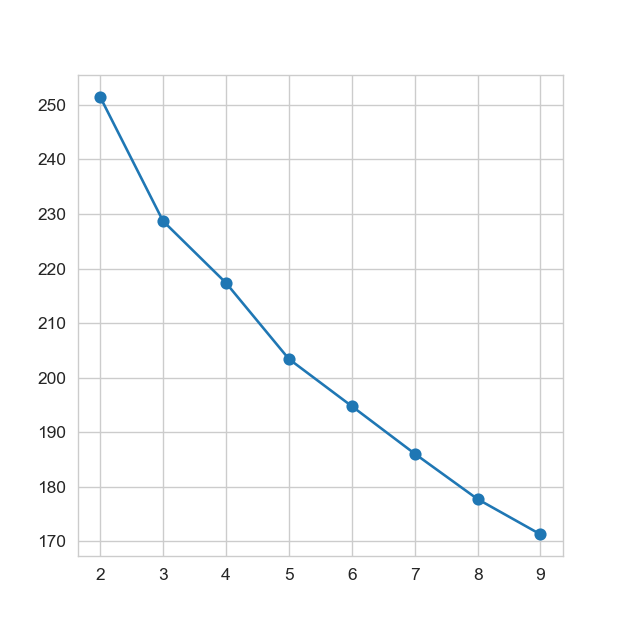

In [69]:
sns.set_style(style)
# Apply Kmeans
# Create lists to hold values
Ks = []
k = []

for K in range(2,10):
    kmeans = KMeans(n_clusters=K, random_state=rs, init="k-means++").fit(x_cols)
    Ks.append(kmeans.inertia_)
    k.append(K)
# Plot K values
plt.figure(figsize=(5,5))
plt.plot(k, Ks, '-o');

There is really not much of an elbow, but it looks like 3 or 4 clusters is what we are looking for.  
We'll create a scatter plot of the centers of each cluster for a quik visual comparison.

In [15]:
kmeans = KMeans(n_clusters=3, random_state=rs).fit(x_cols)
centers = kmeans.cluster_centers_
plt.ylim(-0.1,0.5)
plt.xlim(-0.1,0.5)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5])
plt.xticks([0,0.1,0.2,0.3,0.4,0.5])
plt.scatter(centers[:, 0], centers[:, 1]);

In [16]:
kmeans = KMeans(n_clusters=4, random_state=rs).fit(x_cols)
centers = kmeans.cluster_centers_
plt.ylim(-0.1,0.5)
plt.xlim(-0.1,0.5)
plt.yticks([0,0.1,0.2,0.3,0.4,0.5])
plt.xticks([0,0.1,0.2,0.3,0.4,0.5])
plt.scatter(centers[:, 0], centers[:, 1]);

It looks like 3 clustes gives more defined grouping.  
We can look at different visualizations to make a better determination later.

## Because there was not a distinct elbow I searched the web for an example of the same use of KMeans.

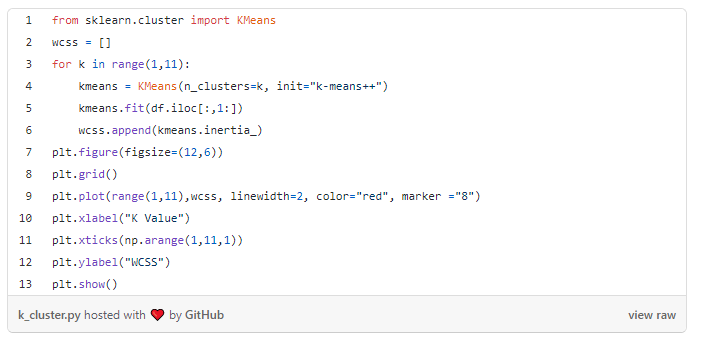

In [12]:
Image(filename='PCACode.png')

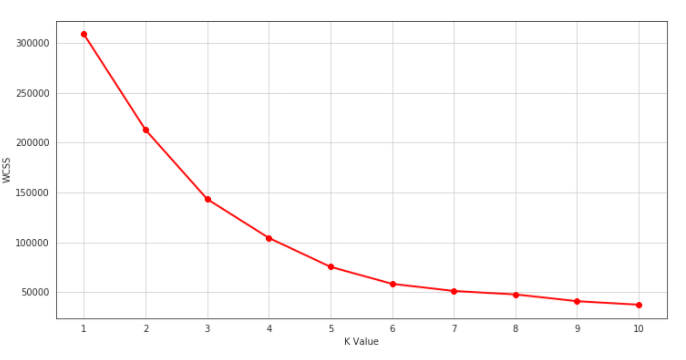

In [13]:
Image(filename='PCAGraph.png')

# Try something different  
I'm going to try the samething wihtout aggregating the rows by customer name.

In [14]:
df_encoded2.head()

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Smith,0,1,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,Smith,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
2,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Johnson,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,0
4,Johnson,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0


In [15]:
x_cols2 = df_encoded2.drop(['customer_name'], axis=1).to_numpy()
x_cols2

array([[0, 1, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 1, 0]], dtype=uint8)

In [16]:
sns.set_style(style)
# Apply Kmeans
Ks = []
k = []

for K in range(2,11):
    kmeans = KMeans(n_clusters=K, random_state=rs, init="k-means++").fit(x_cols2)
    Ks.append(kmeans.inertia_)
    k.append(K)
# Plot K values
plt.figure(figsize=(5,5))
plt.plot(k, Ks, '-o');

NameError: name 'KMeans' is not defined

## Stilll not a very distinct elbow.

## Choosing K: The Silhouette Method

There exists another method that measures how well each datapoint $x_i$ "fits" its assigned cluster *and also* how poorly it fits into other clusters. This is a different way of looking at the same objective. Denote $a_{x_i}$ as the *average* distance from $x_i$ to all other points within its own cluster $k$. The lower the value, the better. On the other hand $b_{x_i}$ is the minimum average distance from $x_i$ to points in a different cluster, minimized over clusters. That is, compute separately for each cluster the average distance from $x_i$ to the points within that cluster, and then take the minimum. The silhouette $s(x_i)$ is defined as

$$s(x_i) = \frac{b_{x_i} - a_{x_i}}{\max{\left( a_{x_i}, b_{x_i}\right)}}$$

The silhouette score is computed on *every datapoint in every cluster*. The silhouette score ranges from -1 (a poor clustering) to +1 (a very dense clustering) with 0 denoting the situation where clusters overlap. Some criteria for the silhouette coefficient is provided in the table below.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

**Hint**: Scikit-learn provides a function to compute this for us (phew!) called [`sklearn.metrics.silhouette_score`](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.silhouette_score.html). Take a look at [this article](http://scikit-learn.org/stable/auto_examples/cluster/plot_kmeans_silhouette_analysis.html) on picking $K$ in scikit-learn, as it will help you in the next exercise set.

In [22]:
df_encoded.head()

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [23]:
X = df_encoded.drop('customer_name', axis=1).to_numpy()
X

array([[0, 0, 0, ..., 1, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 1, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 1, 1]], dtype=uint8)

In [24]:
y = df_encoded[['customer_name']]
y.head()

,customer_name
0,Adams
1,Allen
2,Anderson
3,Bailey
4,Baker


<IPython.core.display.Javascript object>


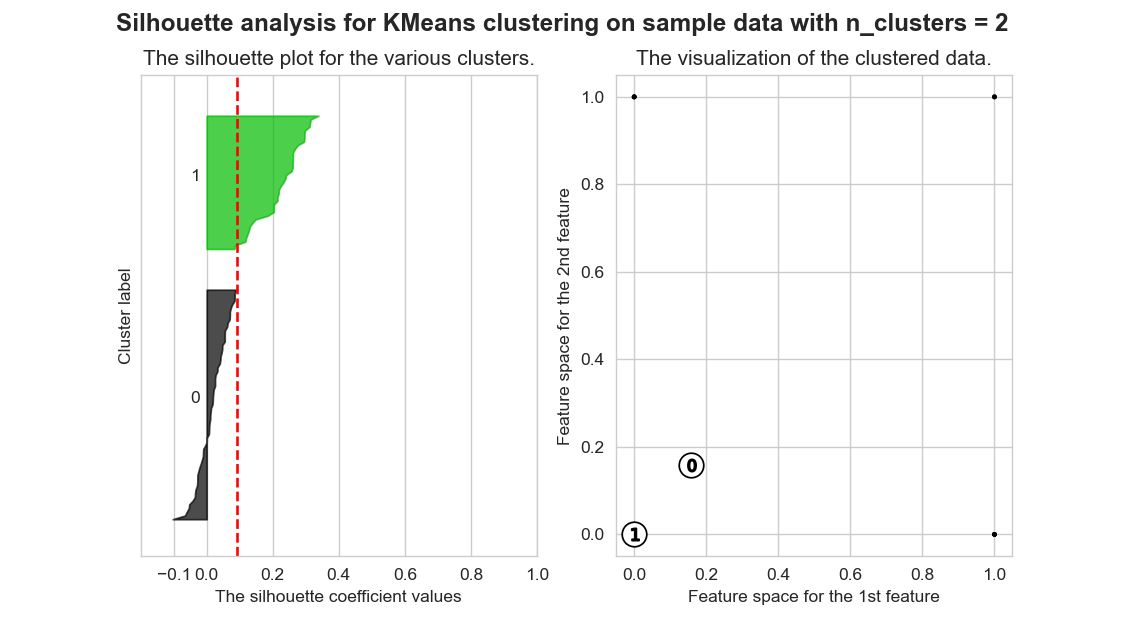

For n_clusters = 2 The average silhouette_score is : 0.09174871508750351


<IPython.core.display.Javascript object>


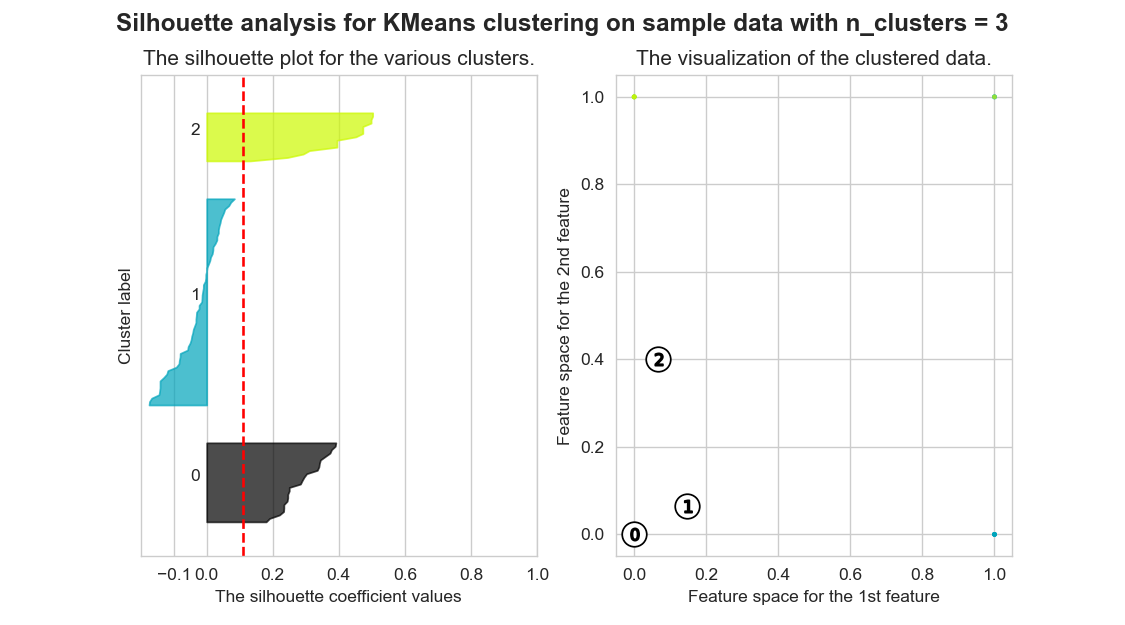

For n_clusters = 3 The average silhouette_score is : 0.1107183912025193


<IPython.core.display.Javascript object>


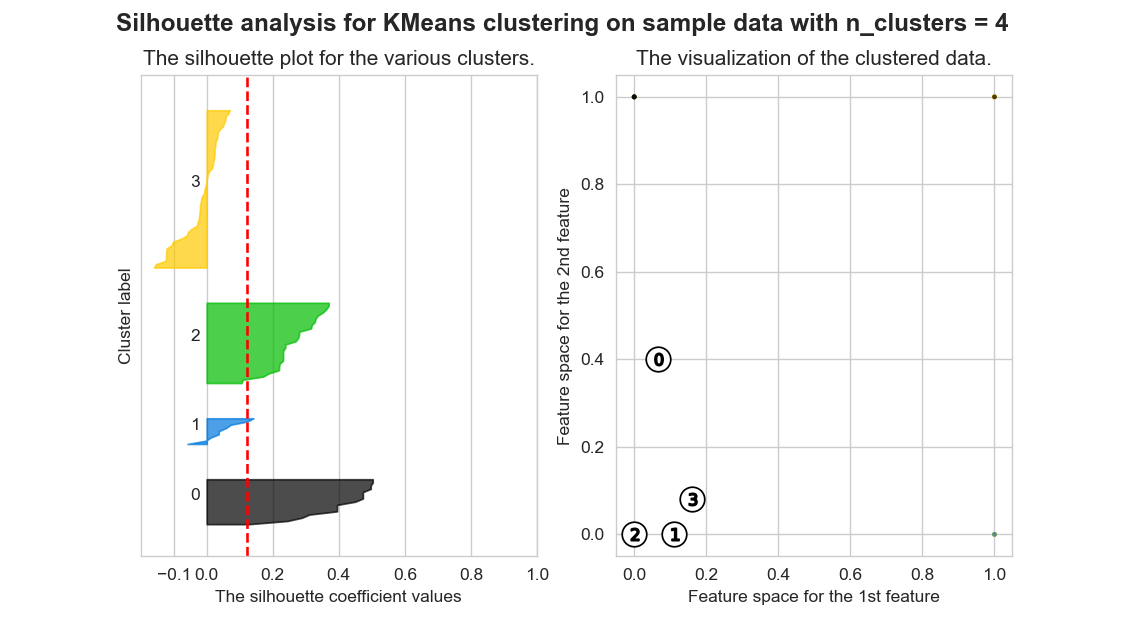

For n_clusters = 4 The average silhouette_score is : 0.12349204708263416


<IPython.core.display.Javascript object>


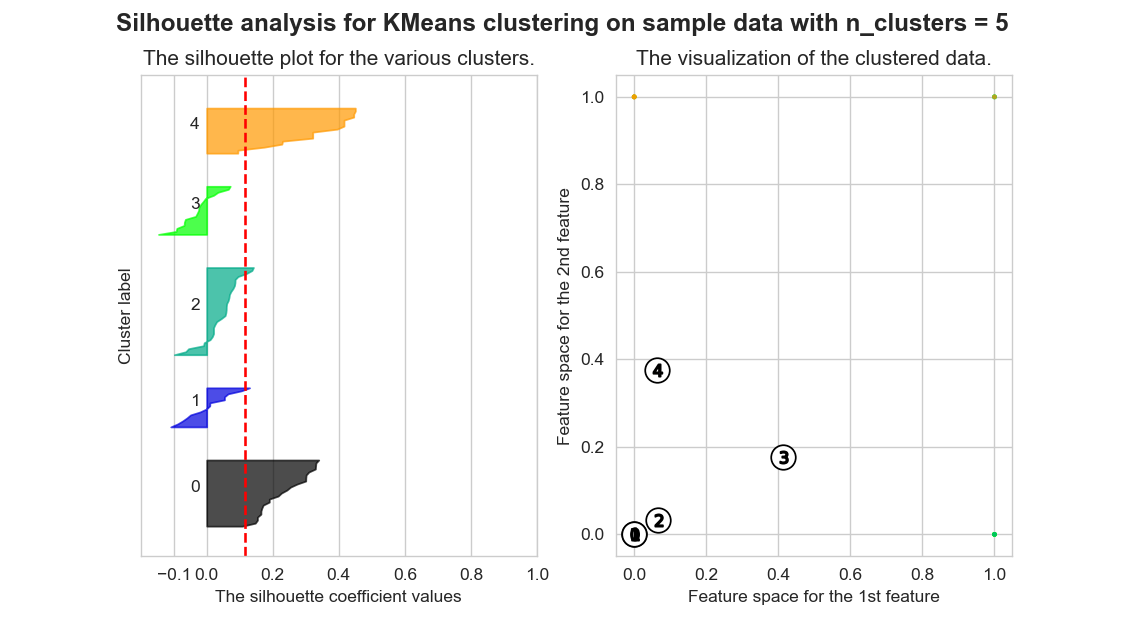

For n_clusters = 5 The average silhouette_score is : 0.11482891379977885


<IPython.core.display.Javascript object>


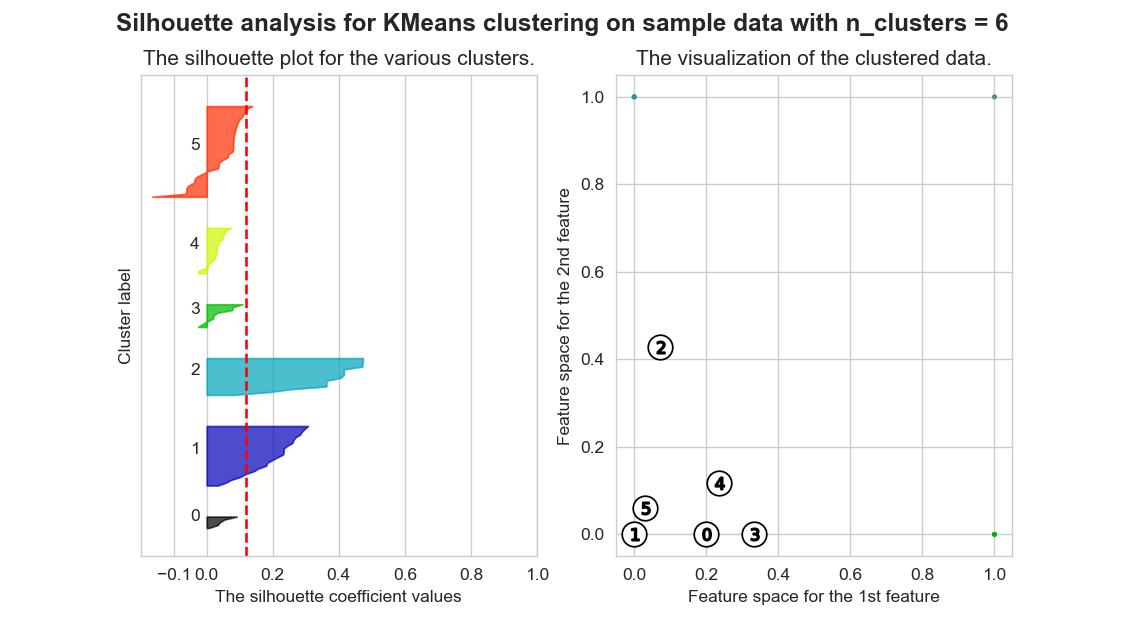

For n_clusters = 6 The average silhouette_score is : 0.11879508142787866


In [25]:
sns.set_style(style)
# Your turn.
from sklearn.metrics import silhouette_samples, silhouette_score

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np

range_n_clusters = [2, 3, 4, 5, 6]

for n_clusters in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(9, 5)

    # The 1st subplot is the silhouette plot
    # The silhouette coefficient can range from -1, 1 but in this example all
    # lie within [-0.1, 1]
    ax1.set_xlim([-0.2, 1])
    # The (n_clusters+1)*10 is for inserting blank space between silhouette
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(X) + (n_clusters + 1) * 10])

    # Initialize the clusterer with n_clusters value
    clusterer = KMeans(n_clusters=n_clusters, random_state=rs)
    cluster_labels = clusterer.fit_predict(X)

    # The silhouette_score gives the average value for all the samples.
    # This gives a perspective into the density and separation of the formed
    # clusters
    silhouette_avg = silhouette_score(X, cluster_labels)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(X, cluster_labels)

    y_lower = 10
    for i in range(n_clusters):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / n_clusters)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / n_clusters)
    ax2.scatter(X[:, 0], X[:, 1], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusterer.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % n_clusters),
                 fontsize=14, fontweight='bold')

plt.show()

The highest silhouette score is at 4 clusters, 0.123, suggesting that there are 4 unique clusters.  
But looking at the interpretations below, it is indicating that there is no substantial structure.

<pre>

| Range       | Interpretation                                |
|-------------|-----------------------------------------------|
| 0.71 - 1.0  | A strong structure has been found.            |
| 0.51 - 0.7  | A reasonable structure has been found.        |
| 0.26 - 0.5  | The structure is weak and could be artificial.|
| < 0.25      | No substantial structure has been found.      |

</pre>
Source: http://www.stat.berkeley.edu/~spector/s133/Clus.html

##  Choosing $K$: The Gap Statistic

There is one last method worth covering for picking $K$, the so-called Gap statistic. The computation for the gap statistic builds on the sum-of-squares established in the Elbow method discussion, and compares it to the sum-of-squares of a "null distribution," that is, a random set of points with no clustering. The estimate for the optimal number of clusters $K$ is the value for which $\log{SS}$ falls the farthest below that of the reference distribution:

$$G_k = E_n^*\{\log SS_k\} - \log SS_k$$

In other words a good clustering yields a much larger difference between the reference distribution and the clustered data. The reference distribution is a Monte Carlo (randomization) procedure that constructs $B$ random distributions of points within the bounding box (limits) of the original data and then applies K-means to this synthetic distribution of data points.. $E_n^*\{\log SS_k\}$ is just the average $SS_k$ over all $B$ replicates. We then compute the standard deviation $\sigma_{SS}$ of the values of $SS_k$ computed from the $B$ replicates of the reference distribution and compute

$$s_k = \sqrt{1+1/B}\sigma_{SS}$$

Finally, we choose $K=k$ such that $G_k \geq G_{k+1} - s_{k+1}$.

## Aside: Choosing $K$ when we Have Labels

Unsupervised learning expects that we do not have the labels. In some situations, we may wish to cluster data that is labeled. Computing the optimal number of clusters is much easier if we have access to labels. There are several methods available. We will not go into the math or details since it is rare to have access to the labels, but we provide the names and references of these measures.

* Adjusted Rand Index
* Mutual Information
* V-Measure
* Fowlkes–Mallows index

**Hint:** See [this article](http://scikit-learn.org/stable/modules/clustering.html) for more information about these metrics.

## Visualizing Clusters using PCA

How do we visualize clusters? If we only had two features, we could likely plot the data as is. But we have 100 data points each containing 32 features (dimensions). Principal Component Analysis (PCA) will help us reduce the dimensionality of our data from 32 to something lower. For a visualization on the coordinate plane, we will use 2 dimensions. In this exercise, we're going to use it to transform our multi-dimensional dataset into a 2 dimensional dataset.

This is only one use of PCA for dimension reduction. We can also use PCA when we want to perform regression but we have a set of highly correlated variables. PCA untangles these correlations into a smaller number of features/predictors all of which are orthogonal (not correlated). PCA is also used to reduce a large set of variables into a much smaller one.

**Hint:** PCA was discussed in the previous subunit. If you need help with it, consult [this useful article](https://towardsdatascience.com/a-one-stop-shop-for-principal-component-analysis-5582fb7e0a9c) and [this visual explanation](http://setosa.io/ev/principal-component-analysis/). 

<div class="span5 alert alert-info">
<h3>Checkup Exercise Set IV</h3>

<p><b>Exercise:</b> Use PCA to plot your clusters:</p>

<ul>
<li> Use scikit-learn's [`PCA`](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) function to reduce the dimensionality of your clustering data to 2 components
<li> Create a data frame with the following fields:
  <ul>
  <li> customer name
  <li> cluster id the customer belongs to
  <li> the two PCA components (label them `x` and `y`)
  </ul>
<li> Plot a scatterplot of the `x` vs `y` columns
<li> Color-code points differently based on cluster ID
<li> How do the clusters look? 
<li> Based on what you see, what seems to be the best value for $K$? Moreover, which method of choosing $K$ seems to have produced the optimal result visually?
</ul>

<p><b>Exercise:</b> Now look at both the original raw data about the offers and transactions and look at the fitted clusters. Tell a story about the clusters in context of the original data. For example, do the clusters correspond to wine variants or something else interesting?</p>
</div>

In [17]:
from sklearn.decomposition import PCA

In [18]:
x_pca = PCA(n_components=2, random_state=rs).fit_transform(x_cols)

NameError: name 'rs' is not defined

In [19]:
x_pca.shape

NameError: name 'x_pca' is not defined

We now have our 100 rows of data reduce to two simple dimensions.  
We can now plot our data and get a visual look at the clusters.  

<IPython.core.display.Javascript object>


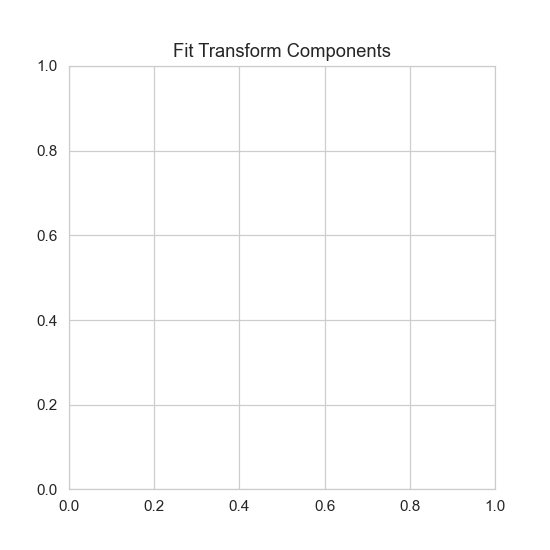

NameError: name 'x_pca' is not defined

In [20]:
sns.set_style(style)
plt.figure(figsize=(5,5))
plt.title('Fit Transform Components')
plt.scatter(x_pca[:, 0], x_pca[:, 1], s=20);

Looking at the scatter plot I can see 3 clusters, maybe 4.  
We can use KMeans on our data to cluster into 3 and 4 groups for another look.  

We are going to add our customer name back into our dataframe so we can target each customer by the cluster that they appear in.

In [21]:
principalDf = pd.DataFrame(data=x_pca, columns=['X', 'Y'])
principalDf['Customer'] = y['customer_name']
principalDf.head()

NameError: name 'x_pca' is not defined

When using KMeans we need to inicate how many cluster we are looking for.  
So far our data has pointed to either 3 or 4 distint clusters.  
We are going to run the KMeans model on our data with clusters ranging from 2 to 10.  
By plotting the sum of the squared distances to their closest cluster center.  
  
  
By observing the rate of change of the squared sum from one number of clusters to the next, we can get an idea of when increasing the number of clusters decreases the change of our squared sums, indicating that the clusters are becoming less defined.

In [22]:
sns.set_style(style)
# Apply Kmeans
Ks = []
k = []

for K in range(1,11):
    kmeans = KMeans(n_clusters=K, random_state=rs, init="k-means++").fit(x_pca)
    Ks.append(kmeans.inertia_)
    k.append(K)
# Plot K values

plt.figure(figsize=(5,5))
plt.xticks(np.arange(0,12))
plt.xlabel('Number of Components')
plt.plot(k, Ks, '-o');
# plt.yscale('log')

NameError: name 'KMeans' is not defined

This graph gives us the same answer we've been seeing regarding cluster numbers, either 3 or 4 is going to give the best cluster definition.

In [23]:
# Run KMeans with 3 clusters and store in labels in the dataframe

kmeans = KMeans(n_clusters=3, random_state=rs, init="k-means++").fit(x_pca)
Kpred = kmeans.predict(x_pca)
principalDf['3 Cluster'] = Kpred

NameError: name 'KMeans' is not defined

In [24]:
# Run KMeans with 4 clusters and store in labels in the dataframe

kmeans = KMeans(n_clusters=4, random_state=rs, init="k-means++").fit(x_pca)
Kpred = kmeans.predict(x_pca)
principalDf['4 Cluster'] = Kpred

principalDf.head()

NameError: name 'KMeans' is not defined

In [25]:
# Plot two scatter plots, one showing 3 clusters and one showing 4
sns.set_style(style)

X = principalDf['X']
Y = principalDf['Y']
cluster3 = principalDf['3 Cluster']
cluster4 = principalDf['4 Cluster']

fig, axes= plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('3 Clusters')
axes[1].set_title('4 Clusters')

p1 = sns.scatterplot(ax=axes[0], x=X, y=Y, data=principalDf, hue=cluster3)
p1.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
p2 = sns.scatterplot(ax=axes[1], x=X, y=Y, data=principalDf, hue=cluster4)
p2.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[]);

NameError: name 'principalDf' is not defined

What we've done is we've taken those columns of 0/1 indicator variables, and we've transformed them into a 2-D dataset. We took one column and arbitrarily called it `x` and then called the other `y`. Now we can throw each point into a scatterplot. We color coded each point based on it's cluster so it's easier to see them.

In [26]:
x_pca = PCA(n_components=10, random_state=10).fit(x_cols)

NameError: name 'x_cols' is not defined

<IPython.core.display.Javascript object>


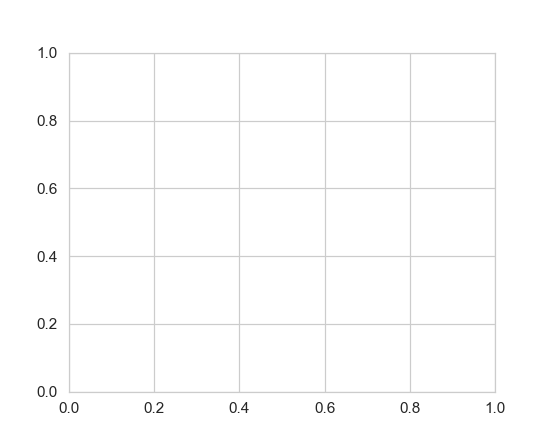

NameError: name 'x_pca' is not defined

In [27]:
sns.set_style(style)
plt.subplots(figsize=(5,4))
plt.plot(x_pca.explained_variance_ratio_.cumsum())
plt.plot(x_pca.explained_variance_ratio_)
plt.xlabel('Component #')
plt.xticks([0,1,2,3,4,5,6,7,8,9],['1','2','3','4','5','6','7','8','9','10'])
plt.ylabel('Cumulative Ratio Variance')
plt.title('Cumulative Variance Ratio explained by PCA components')
plt.legend(['Cumulative Sum', 'Variance Ratio']);

<IPython.core.display.Javascript object>


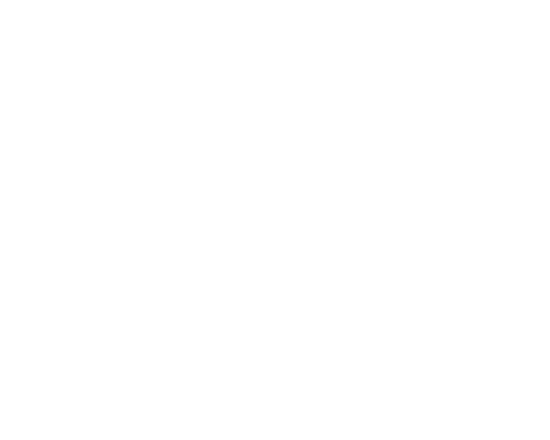

NameError: name 'x_pca' is not defined

In [28]:
# Variance Ratio
sns.set_style(style)
plt.figure(figsize=(5,4))
plt.plot(x_pca.explained_variance_ratio_)
plt.xticks([0,1,2,3,4,5,6,7,8,9],['1','2','3','4','5','6','7','8','9','10'])
plt.xlabel("Number of Components")
plt.ylabel("Proportion of Variance Explained")
plt.show()

In [29]:
# Initialize a new PCA model with a default number of components.

import sklearn.decomposition
x_pca = PCA(random_state=rs).fit(x_cols)


NameError: name 'rs' is not defined

In [30]:
variance = x_pca.explained_variance_
sns.set_style(style)
plt.figure(figsize=(7,5))
plt.plot(range(len(variance)), variance)
plt.xticks(np.arange(0,33))
plt.xlabel("Number of Components")
plt.ylabel("Explained Variance");

NameError: name 'x_pca' is not defined

## 4. Conclusions and next steps
### 4a. Conclusions
What can you conclude from your investigations? Make a note, formulate it as clearly as possible, and be prepared to discuss it with your mentor in your next call. 

### 4b. Other clustering algorithms

k-means is only one of a ton of clustering algorithms. Below is a brief description of several clustering algorithms, and the table provides references to the other clustering algorithms in scikit-learn. 

* **Affinity Propagation** does not require the number of clusters $K$ to be known in advance! AP uses a "message passing" paradigm to cluster points based on their similarity. 

* **Spectral Clustering** uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

* **Ward's Method** applies to hierarchical clustering. Hierarchical clustering algorithms take a set of data and successively divide the observations into more and more clusters at each layer of the hierarchy. Ward's method is used to determine when two clusters in the hierarchy should be combined into one. It is basically an extension of hierarchical clustering. Hierarchical clustering is *divisive*, that is, all observations are part of the same cluster at first, and at each successive iteration, the clusters are made smaller and smaller. With hierarchical clustering, a hierarchy is constructed, and there is not really the concept of "number of clusters." The number of clusters simply determines how low or how high in the hierarchy we reference and can be determined empirically or by looking at the [dendogram](https://docs.scipy.org/doc/scipy-0.18.1/reference/generated/scipy.cluster.hierarchy.dendrogram.html).

* **Agglomerative Clustering** is similar to hierarchical clustering but but is not divisive, it is *agglomerative*. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

* **DBSCAN** is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

### Clustering Algorithms in Scikit-learn
<table border="1">
<colgroup>
<col width="15%" />
<col width="16%" />
<col width="20%" />
<col width="27%" />
<col width="22%" />
</colgroup>
<thead valign="bottom">
<tr><th>Method name</th>
<th>Parameters</th>
<th>Scalability</th>
<th>Use Case</th>
<th>Geometry (metric used)</th>
</tr>
</thead>
<tbody valign="top">
<tr><td>K-Means</span></a></td>
<td>number of clusters</td>
<td>Very large<span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span> with
MiniBatch code</td>
<td>General-purpose, even cluster size, flat geometry, not too many clusters</td>
<td>Distances between points</td>
</tr>
<tr><td>Affinity propagation</td>
<td>damping, sample preference</td>
<td>Not scalable with n_samples</td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Mean-shift</td>
<td>bandwidth</td>
<td>Not scalable with <span class="pre">n_samples</span></td>
<td>Many clusters, uneven cluster size, non-flat geometry</td>
<td>Distances between points</td>
</tr>
<tr><td>Spectral clustering</td>
<td>number of clusters</td>
<td>Medium <span class="pre">n_samples</span>, small <span class="pre">n_clusters</span></td>
<td>Few clusters, even cluster size, non-flat geometry</td>
<td>Graph distance (e.g. nearest-neighbor graph)</td>
</tr>
<tr><td>Ward hierarchical clustering</td>
<td>number of clusters</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints</td>
<td>Distances between points</td>
</tr>
<tr><td>Agglomerative clustering</td>
<td>number of clusters, linkage type, distance</td>
<td>Large <span class="pre">n_samples</span> and <span class="pre">n_clusters</span></td>
<td>Many clusters, possibly connectivity constraints, non Euclidean
distances</td>
<td>Any pairwise distance</td>
</tr>
<tr><td>DBSCAN</td>
<td>neighborhood size</td>
<td>Very large <span class="pre">n_samples</span>, medium <span class="pre">n_clusters</span></td>
<td>Non-flat geometry, uneven cluster sizes</td>
<td>Distances between nearest points</td>
</tr>
<tr><td>Gaussian mixtures</td>
<td>many</td>
<td>Not scalable</td>
<td>Flat geometry, good for density estimation</td>
<td>Mahalanobis distances to  centers</td>
</tr>
<tr><td>Birch</td>
<td>branching factor, threshold, optional global clusterer.</td>
<td>Large <span class="pre">n_clusters</span> and <span class="pre">n_samples</span></td>
<td>Large dataset, outlier removal, data reduction.</td>
<td>Euclidean distance between points</td>
</tr>
</tbody>
</table>
Source: http://scikit-learn.org/stable/modules/clustering.html

# Affinity Propagation  
  
AffinityPropagation creates clusters by sending messages between pairs of samples until convergence. A dataset is then described using a small number of exemplars, which are identified as those most representative of other samples. The messages sent between pairs represent the suitability for one sample to be the exemplar of the other, which is updated in response to the values from other pairs. This updating happens iteratively until convergence, at which point the final exemplars are chosen, and hence the final clustering is given.  

We are using the original encoded dataframe with 100 rows and 33 columns.  
We will convert it to a numpy array as before.

In [40]:
df_encoded.head()

,customer_name,offer_id_1,offer_id_2,offer_id_3,offer_id_4,offer_id_5,offer_id_6,offer_id_7,offer_id_8,offer_id_9,...,offer_id_23,offer_id_24,offer_id_25,offer_id_26,offer_id_27,offer_id_28,offer_id_29,offer_id_30,offer_id_31,offer_id_32
0,Adams,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,1,0,0
1,Allen,0,0,0,0,0,0,0,0,1,...,0,0,0,0,1,0,0,0,0,0
2,Anderson,0,0,0,0,0,0,0,0,0,...,0,1,0,1,0,0,0,0,0,0
3,Bailey,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,1,0,0
4,Baker,0,0,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,1,0


In [41]:
x_cols = df_encoded.drop(['customer_name'], axis=1).to_numpy()
x_cols.shape

(100, 32)

We are going to run the affinity progagation model with parameters to produce 3 and 4 clusters.  
This is by no means a comprehensive look at the possibilities available with affinity propagation.  
This information is to help us decide if this model is worth investigation.  

We are going to append the cluster values to our pricipal dataframe for plotting.

In [42]:
from sklearn.cluster import AffinityPropagation

# Fit affinity propagation to find 3 clusters
afprop = AffinityPropagation(damping=0.9, preference=-25, random_state=rs)
afprop.fit(x_cols)
cluster_center_indices = afprop.cluster_centers_indices_
n_clusters = len(cluster_center_indices)
print(n_clusters, 'Clusters')
cluster_centers = afprop.cluster_centers_

3 Clusters


In [43]:
# Predict to produce cluster labels
P = afprop.predict(x_cols)

principalDf['AP Cluster3'] = P
principalDf.head()

,X,Y,Customer,3 Cluster,4 Cluster,AP Cluster3
0,1.007580,0.108215,Adams,0,0,0
1,-0.287539,0.044715,Allen,1,3,0
2,-0.392032,1.038391,Anderson,2,2,2
3,0.699477,-0.022542,Bailey,0,0,0
4,0.088183,-0.471695,Baker,1,3,0


In [44]:
# Fit affinity propagation to find 4 clusters
afprop = AffinityPropagation(damping=0.9, preference=-20, random_state=rs)
afprop.fit(x_cols)
cluster_center_indices = afprop.cluster_centers_indices_
n_clusters = len(cluster_center_indices)
print(n_clusters, 'Clusters')
cluster_centers = afprop.cluster_centers_


4 Clusters


In [45]:
# Predict to produce cluster labels
P = afprop.predict(x_cols)

principalDf['AP Cluster4'] = P
principalDf.head()

,X,Y,Customer,3 Cluster,4 Cluster,AP Cluster3,AP Cluster4
0,1.007580,0.108215,Adams,0,0,0,0
1,-0.287539,0.044715,Allen,1,3,0,2
2,-0.392032,1.038391,Anderson,2,2,2,3
3,0.699477,-0.022542,Bailey,0,0,0,0
4,0.088183,-0.471695,Baker,1,3,0,2


There is a lot more experimentation that could take place with this model by varying the damping and preference.

<IPython.core.display.Javascript object>


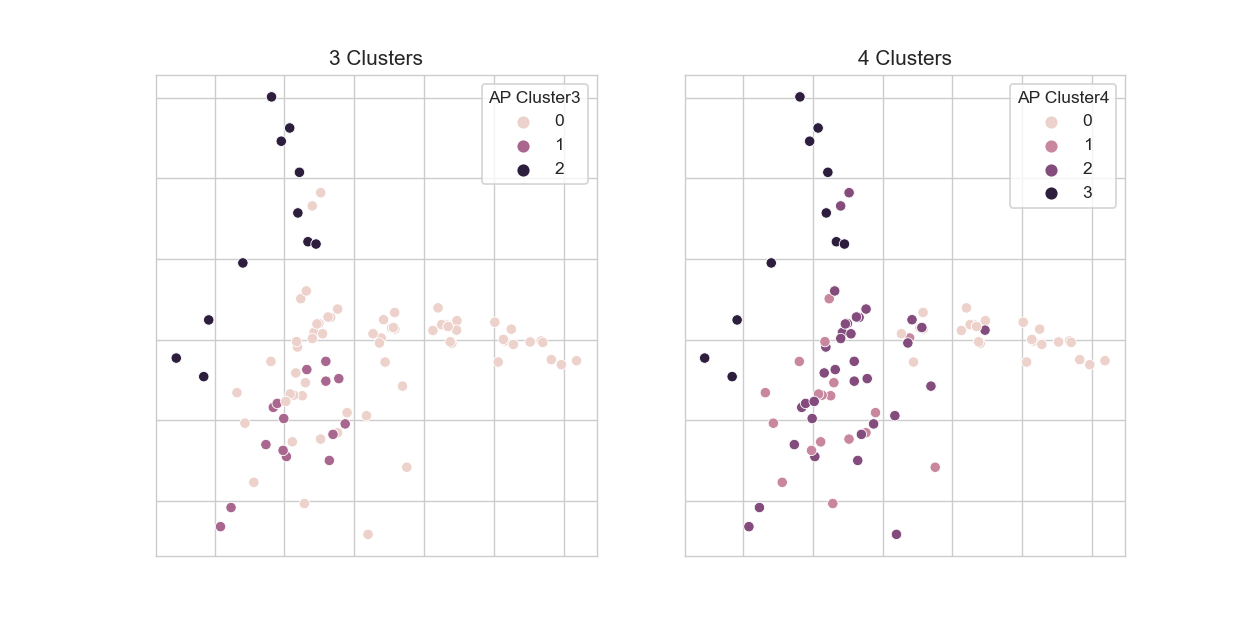

In [46]:
# Plot two scatter plots, one showing 3 clusters and one showing 4
sns.set_style(style)
X = principalDf['X']
Y = principalDf['Y']
cluster3 = principalDf['AP Cluster3']
cluster4 = principalDf['AP Cluster4']

fig, axes= plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('3 Clusters')
axes[1].set_title('4 Clusters')

p1 = sns.scatterplot(ax=axes[0], x=X, y=Y, data=principalDf, hue=cluster3)
p1.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
p2 = sns.scatterplot(ax=axes[1], x=X, y=Y, data=principalDf, hue=cluster4)
p2.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[]);

These clusters make sense, but are no more useful than our previous KMeans clusters.

# Spectral Clustering  

Spectral Clustering uses the eigenvalues of a similarity matrix to reduce the dimensionality of the data before clustering in a lower dimensional space. This is tangentially similar to what we did to visualize k-means clusters using PCA. The number of clusters must be known a priori.

In [47]:
# Create an affinity matrix to use later for spectral clustering

mat = afprop.affinity_matrix_
mat.shape

(100, 100)

In [48]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
smat = scaler.fit_transform(mat)
smat.shape

(100, 100)

In [49]:
from sklearn.cluster import SpectralClustering

s_cluster = SpectralClustering(n_clusters=3).fit_predict(x_cols)
principalDf['SC3'] = s_cluster

In [50]:
s_cluster = SpectralClustering(n_clusters=4).fit_predict(x_cols)
principalDf['SC4'] = s_cluster

principalDf.head()

,X,Y,Customer,3 Cluster,4 Cluster,AP Cluster3,AP Cluster4,SC3,SC4
0,1.007580,0.108215,Adams,0,0,0,0,2,1
1,-0.287539,0.044715,Allen,1,3,0,2,1,0
2,-0.392032,1.038391,Anderson,2,2,2,3,0,2
3,0.699477,-0.022542,Bailey,0,0,0,0,2,1
4,0.088183,-0.471695,Baker,1,3,0,2,1,0


<IPython.core.display.Javascript object>


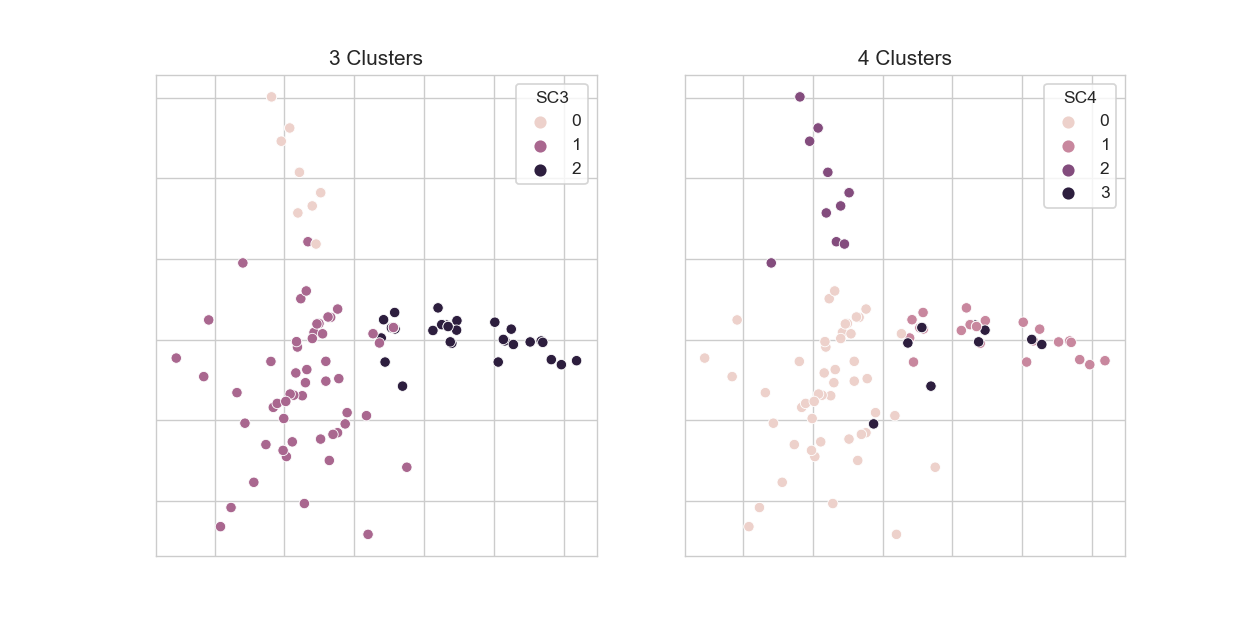

In [51]:
# Plot two scatter plots, one showing 3 clusters and one showing 4
sns.set_style(style)
X = principalDf['X']
Y = principalDf['Y']
cluster3 = principalDf['SC3']
cluster4 = principalDf['SC4']

fig, axes= plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('3 Clusters')
axes[1].set_title('4 Clusters')

p1 = sns.scatterplot(ax=axes[0], x=X, y=Y, data=principalDf, hue=cluster3)
p1.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
p2 = sns.scatterplot(ax=axes[1], x=X, y=Y, data=principalDf, hue=cluster4)
p2.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[]);

It looks like the 3 cluster plot is more organized.

## Agglomerative Clustering  

Agglomerative Clustering is similar to hierarchical clustering but but is not divisive, it is agglomerative. That is, every observation is placed into its own cluster and at each iteration or level or the hierarchy, observations are merged into fewer and fewer clusters until convergence. Similar to hierarchical clustering, the constructed hierarchy contains all possible numbers of clusters and it is up to the analyst to pick the number by reviewing statistics or the dendogram.

In [52]:
from sklearn.cluster import AgglomerativeClustering

clustering = AgglomerativeClustering(n_clusters=3).fit_predict(x_cols)
principalDf['AG3'] = clustering

In [53]:
clustering = AgglomerativeClustering(n_clusters=4).fit_predict(x_cols)
principalDf['AG4'] = clustering
principalDf.head()

,X,Y,Customer,3 Cluster,4 Cluster,AP Cluster3,AP Cluster4,SC3,SC4,AG3,AG4
0,1.007580,0.108215,Adams,0,0,0,0,2,1,1,1
1,-0.287539,0.044715,Allen,1,3,0,2,1,0,0,0
2,-0.392032,1.038391,Anderson,2,2,2,3,0,2,2,2
3,0.699477,-0.022542,Bailey,0,0,0,0,2,1,1,1
4,0.088183,-0.471695,Baker,1,3,0,2,1,0,0,0


<IPython.core.display.Javascript object>


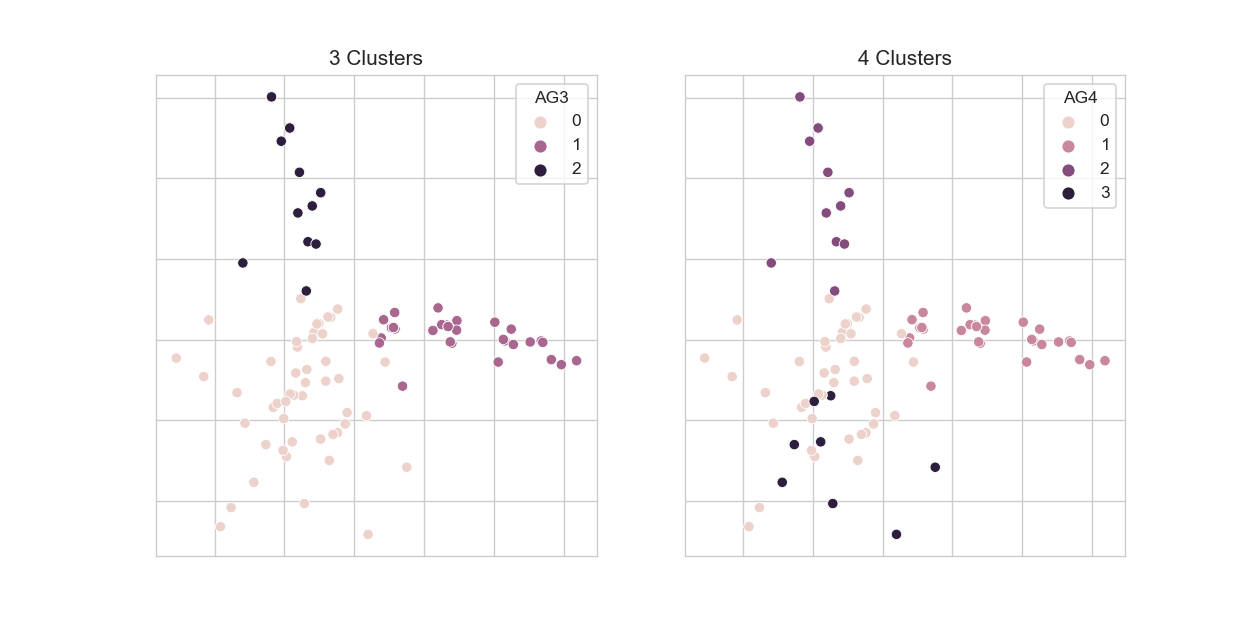

In [54]:
# Plot two scatter plots, one showing 3 clusters and one showing 4
sns.set_style(style)
X = principalDf['X']
Y = principalDf['Y']
cluster3 = principalDf['AG3']
cluster4 = principalDf['AG4']

fig, axes= plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('3 Clusters')
axes[1].set_title('4 Clusters')

p1 = sns.scatterplot(ax=axes[0], x=X, y=Y, data=principalDf, hue=cluster3)
p1.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
p2 = sns.scatterplot(ax=axes[1], x=X, y=Y, data=principalDf, hue=cluster4)
p2.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[]);

## DBSCAN  

DBSCAN is based on point density rather than distance. It groups together points with many nearby neighbors. DBSCAN is one of the most cited algorithms in the literature. It does not require knowing the number of clusters a priori, but does require specifying the neighborhood size.

<IPython.core.display.Javascript object>


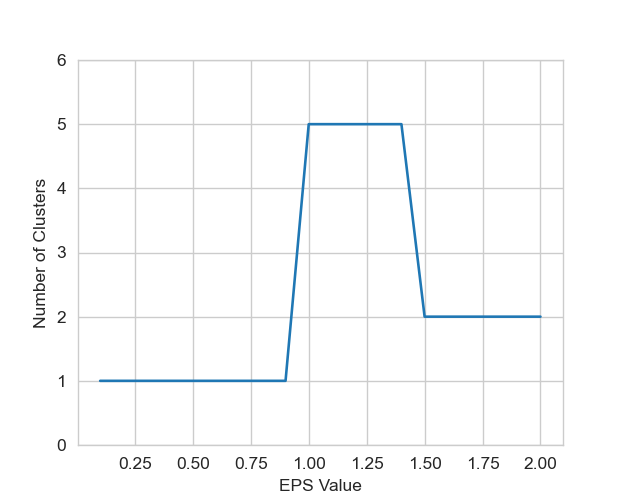

In [55]:
# Import model
sns.set_style(style)
from sklearn.cluster import DBSCAN
db = []

# Test and graph different values for EPS
for i in range(1,21):
    e = (i/10)
    dbscan = DBSCAN(eps=e).fit_predict(x_cols)
    db.append(len(np.unique(dbscan)))

x = (np.arange(1,21)/10)
plt.figure(figsize=(5,4))
plt.yticks([0,1,2,3,4,5,6])
plt.ylabel('Number of Clusters')
plt.xlabel('EPS Value')
plt.ylim(0,6)
plt.plot(x, db);

Looking at the above plot it indicates that we can produce either 1, 2, or 5 clusters.  
We'll plot 2 and 5 clusters.

In [56]:
dbscan = DBSCAN(eps=1.5).fit_predict(x_cols)
principalDf['DB2'] = dbscan

In [57]:
dbscan = DBSCAN(eps=1.3).fit_predict(x_cols)
principalDf['DB5'] = dbscan
principalDf.head()

,X,Y,Customer,3 Cluster,4 Cluster,AP Cluster3,AP Cluster4,SC3,SC4,AG3,AG4,DB2,DB5
0,1.007580,0.108215,Adams,0,0,0,0,2,1,1,1,0,0
1,-0.287539,0.044715,Allen,1,3,0,2,1,0,0,0,0,-1
2,-0.392032,1.038391,Anderson,2,2,2,3,0,2,2,2,0,1
3,0.699477,-0.022542,Bailey,0,0,0,0,2,1,1,1,0,2
4,0.088183,-0.471695,Baker,1,3,0,2,1,0,0,0,-1,-1


<IPython.core.display.Javascript object>


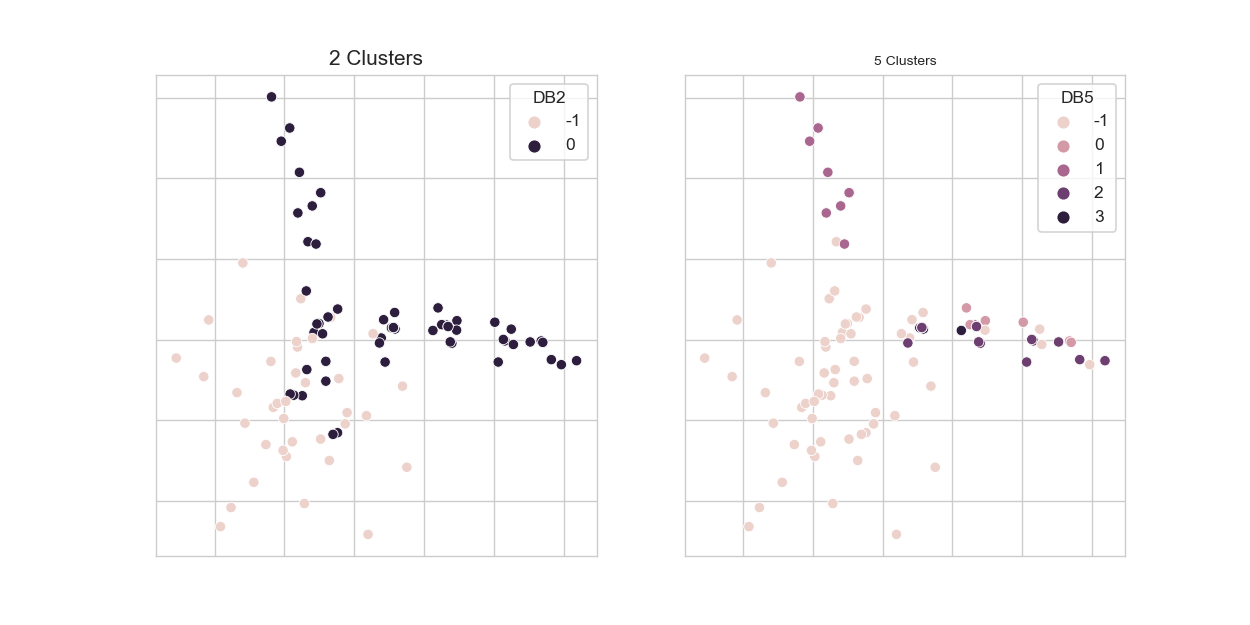

In [58]:
# Plot two scatter plots, one showing 3 clusters and one showing 4
sns.set_style(style)
X = principalDf['X']
Y = principalDf['Y']
cluster3 = principalDf['DB2']
cluster4 = principalDf['DB5']

fig, axes= plt.subplots(1, 2, figsize=(10,5))
axes[0].set_title('2 Clusters', fontsize=12)
axes[1].set_title('5 Clusters', fontsize=8)

p1 = sns.scatterplot(ax=axes[0], x=X, y=Y, data=principalDf, hue=cluster3)
p1.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[])
p2 = sns.scatterplot(ax=axes[1], x=X, y=Y, data=principalDf, hue=cluster4)
p2.set(xlabel=None, ylabel=None, xticklabels=[], yticklabels=[]);

These clusters are not well defined. I feel they are of no use.

# Further experimentation using PCA to reduce our data to 3 dimensions

In [59]:
x3_pca = PCA(n_components=3, random_state=rs).fit_transform(x_cols)
df3d = pd.DataFrame(x3_pca, columns=['X', 'Y', 'Z'])
round(df3d.describe().T, 3)

,count,mean,std,min,25%,50%,75%,max
X,100.0,0.0,0.640,-1.274,-0.422,-0.215,0.354,1.593
Y,100.0,-0.0,0.555,-1.208,-0.331,-0.008,0.119,1.506
Z,100.0,-0.0,0.450,-1.096,-0.285,-0.037,0.308,1.319


<IPython.core.display.Javascript object>


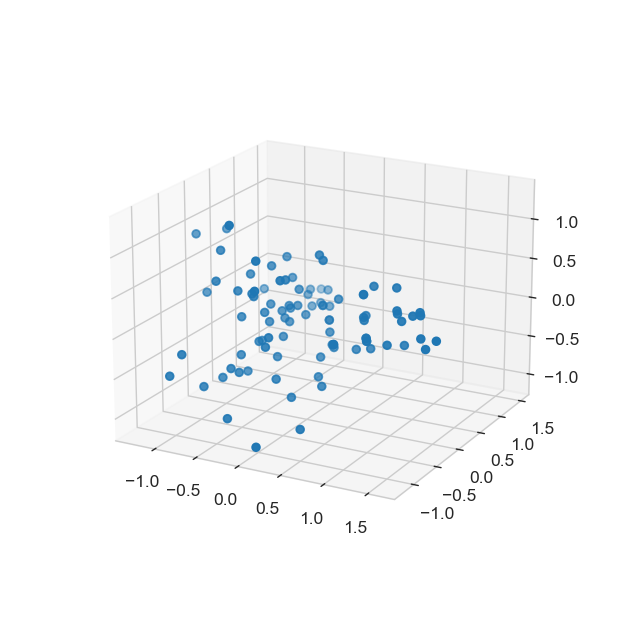

In [60]:
sns.set_style(style)
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111, projection = '3d')

x = df3d['X']
y = df3d['Y']
z = df3d['Z']

ax.scatter(x, y, z)

plt.show()

We are going to add a dimension by applying KMeans to creat 3 clusters.

In [61]:
kmeans = KMeans(n_clusters=3, random_state=rs, init="k-means++").fit(x3_pca)
Kpred = kmeans.predict(x3_pca)
len(Kpred)

100

In [62]:
df3d['Cluster'] = Kpred
df3d.head()

,X,Y,Z,Cluster
0,1.007580,0.108215,0.545614,1
1,-0.287539,0.044715,-0.044072,0
2,-0.392032,1.038391,-0.266342,2
3,0.699477,-0.022542,0.133556,1
4,0.088183,-0.471695,-0.777541,0


<IPython.core.display.Javascript object>


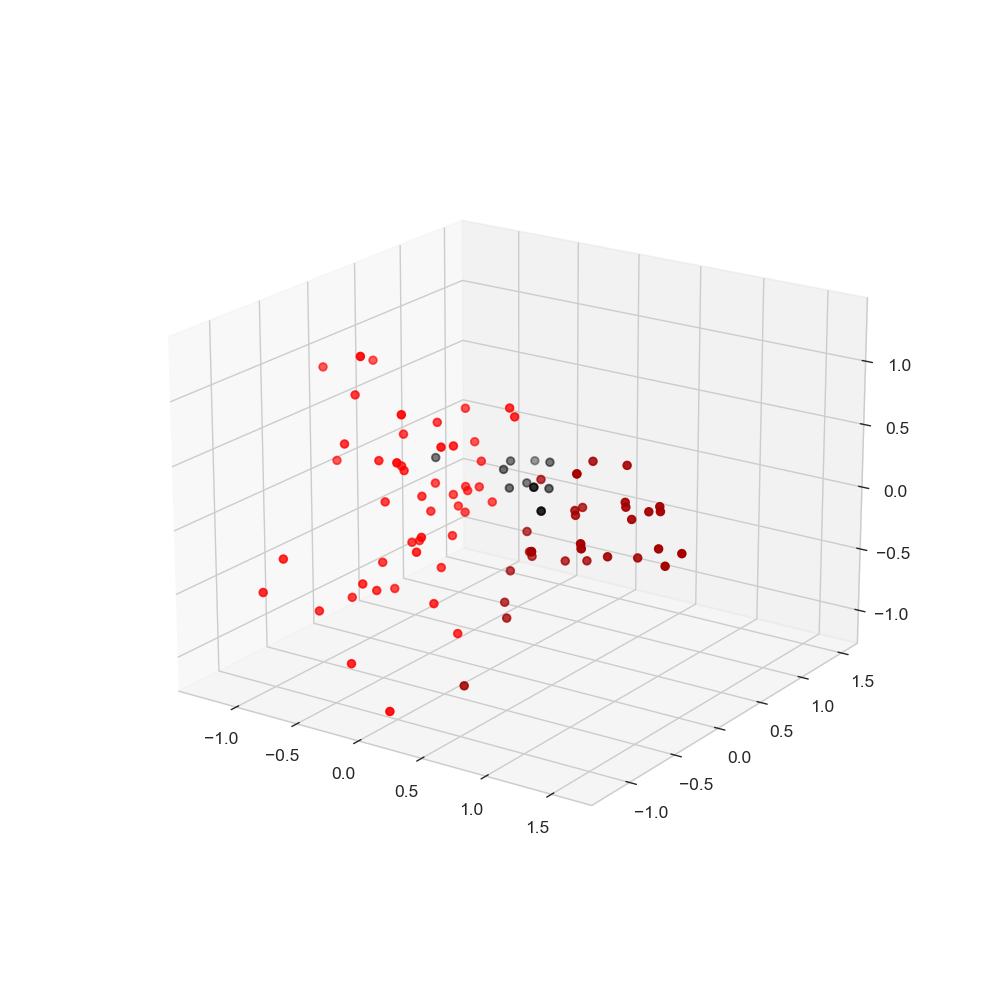

In [63]:
from collections import OrderedDict
sns.set_style(style)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection = '3d')
cmaps = OrderedDict

x = df3d['X']
y = df3d['Y']
z = df3d['Z']
c = df3d['Cluster']

ax.scatter(x, y, z, c=c, cmap='flag')
plt.show()

In [64]:
labels = principalDf['Customer']
x_cols.shape

(100, 32)

# Ward Tree Dendrogram  
Lets take a look at our data as a Dendrogram and see if the information is more clear.

In [65]:
from sklearn.cluster import ward_tree

In [66]:
ward = ward_tree(x_cols, return_distance=True)
children = ward[0]
connected = ward[1]
leaves = ward[2]
distances = ward[4]

<ipython-input-67-fea35fbbb138>:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(10,20))


<IPython.core.display.Javascript object>


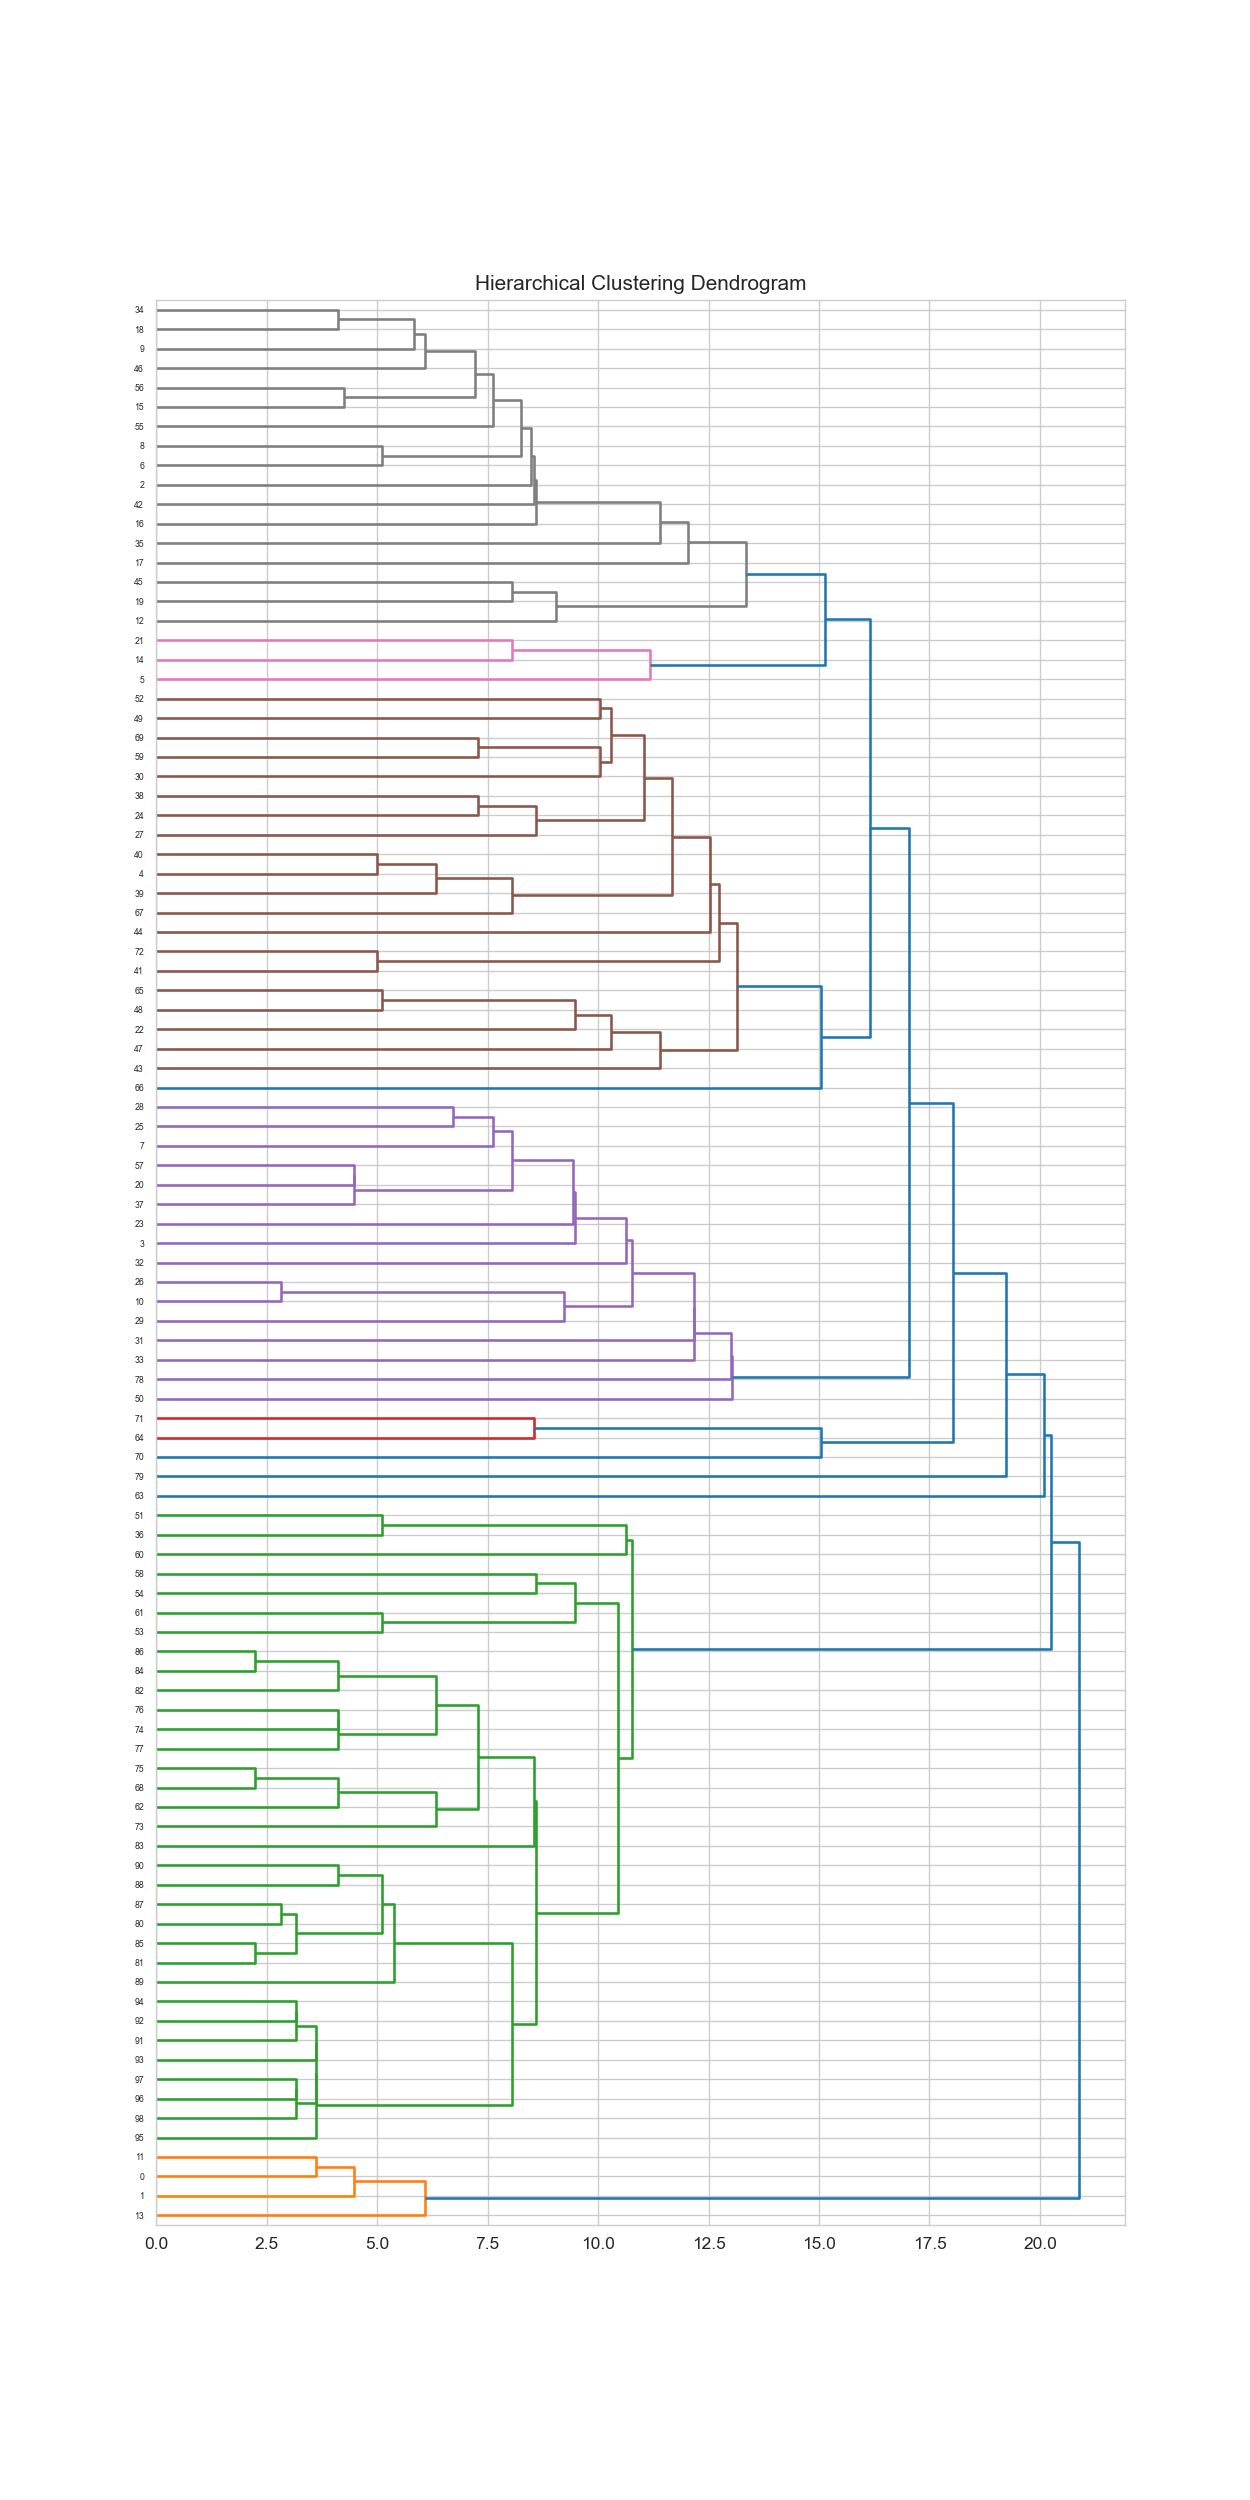

In [67]:
from scipy.cluster.hierarchy import dendrogram, linkage

# Create linkage matrix and then plot the dendrogram
linkage_matrix = linkage(children)

# Plot the corresponding dendrogram
plt.figure(figsize=(10,20))
dendrogram(linkage_matrix, orientation='right')
plt.title('Hierarchical Clustering Dendrogram')
plt.show()

In [68]:
linkage_matrix.shape

(98, 4)